# P.A.R.S.E.C. - PDF Analysis and Review System for Exam Content

This Jupyter Notebook aims to provide a system for analyzing and reviewing PDF documents related to exam content. The notebook will include various functionalities such as parsing PDF files, extracting text and metadata, performing text analysis, generating visualizations, and facilitating the review process. The goal is to create an efficient and comprehensive system for working with exam-related PDF documents.

## Requirements
- python 3.10~
- Elastic instance w/ ELSER Model
- nvidia gpu or llm api key

# Optional
- Langsmith Account/API key (free tier)


In [2]:
#!python3 -m pip install -qU elasticsearch langchain langchain-elasticsearch openai tiktoken PyPDF4

#%pip install PyPDF4
#%pip install elasticsearch
#%pip install langchain
#%pip install langchain-elasticsearch
#%pip install openai tiktoken
#%pip install wordcloud
#%pip install rapidocr-onnxruntime
#%pip install nltk
#%pip install jq
#%pip install ollama

In [3]:
import os 
import re
# import json
from getpass import getpass
from pypdf import PdfReader, PdfWriter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
#from urllib.request import urlopen
#from langchain.text_splitter import RecursiveCharacterTextSplitter
#import multiprocessing
#from multiprocessing import Pool
#import importlib
#import json
#from pathlib import Path
#from typing import Callable, Dict, List, Optional, Union, Any
#from langchain.document_loaders.base import BaseLoader
from langchain.docstore.document import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_elasticsearch import ElasticsearchStore

#from concurrent.futures import ProcessPoolExecutor
#from tqdm import tqdm
#import jq
#from langchain_community.document_loaders import JSONLoader # for non-windows users I suppose


# Download the Punkt tokenizer models (only needed once)
#nltk.download('punkt')

# Preparation of the PDF Files
Get rid of pesky passwords


In [4]:
cwd = os.getcwd()
pdf_files = [f for f in os.listdir(cwd) if f.endswith('.pdf')]
print(pdf_files)

['decrypted_SEC595 - Book 1_2036060.pdf', 'decrypted_SEC595 - Book 2_2036060.pdf', 'decrypted_SEC595 - Book 3_2036060.pdf', 'decrypted_SEC595 - Book 4_2036060.pdf', 'decrypted_SEC595 - Book 5_2036060.pdf', 'decrypted_SEC595 - Book 6_2036060.pdf', 'decrypted_SEC595 - Workbook 1_2036060.pdf', 'decrypted_SEC595 - Workbook 2_2036060.pdf', 'SEC595 - Book 1_2036060.pdf', 'SEC595 - Book 2_2036060.pdf', 'SEC595 - Book 3_2036060.pdf', 'SEC595 - Book 4_2036060.pdf', 'SEC595 - Book 5_2036060.pdf', 'SEC595 - Book 6_2036060.pdf', 'SEC595 - Workbook 1_2036060.pdf', 'SEC595 - Workbook 2_2036060.pdf']


In [5]:
# Skip if already run before
if 'decrypted_'+pdf_files[-1] in os.listdir(cwd):
    print('Already decrypted')
else:
    # Decrypt the PDF files
    for i, pdf_file in enumerate(pdf_files):
        if pdf_file.startswith('decrypted_'):
            continue
        with open(pdf_file, 'rb') as file:
            print(pdf_file, ' is decrypting')
            reader = PdfReader(file)
            # Attempt to decrypt the PDF with an empty password
            if reader.is_encrypted:
                try:
                    reader.decrypt('PpH[uQ(7+Gy:FdA9;X9QVXi@$zVwD-') # Your password here
                except:
                    print("The PDF is encrypted and cannot be decrypted with the password.")
                    break
            
            writer = PdfWriter()
            
            # Copy the content from the original PDF to the new PDF
            for page_num in range(len(reader.pages)):
                page = reader.pages[page_num]
                writer.add_page(page)
            
            # Save the new PDF file without encryption
            with open('decrypted_'+pdf_files[i], 'wb') as output_file:
                writer.write(output_file)
            print("The PDF has been successfully decrypted.")

Already decrypted


# Extracting text and metadata
We'll load the decrypted pdfs, split pages, and so on.
There are books and workbooks within the provided materials and they both require some cleaning. Basically everything after the SANS copyright is useless. For each book we'll take two slices of pages, [4:-1] & [-1]. The former is the course content and the latter is the provided index. For workbooks, we only need one slice [4:]


In [6]:
cwd = os.getcwd()
pdfs = [f for f in os.listdir(cwd) if f.startswith('decrypted_')]
pdfs = [f for f in pdfs if not re.match('.*Workbook.*', f)]

contents = []
for pdf in pdfs:
    loader = PyPDFLoader(pdf)
    pages = loader.load_and_split()
    if 'Workbook' in pages[0].metadata['source']:
        contents.append(pages[4:])
    else:
        contents.extend(pages[4:-1])

len(contents)

445

In [7]:
def clean_document(page_content):
    """
    Clean the document content by removing headers, footers, and any licensing or copyright information.
    """
    cleaned_content = re.sub(r'©.*?SANS Institute \d{4}.*', '', page_content, flags=re.DOTALL)
    cleaned_content = re.sub(r'\S+@\S+', '', cleaned_content)
    cleaned_content = re.sub(r'\s+z', ' ', cleaned_content)
    cleaned_content = cleaned_content.strip().replace('\n', ' ')
    return cleaned_content


for page in contents:
    page.page_content = clean_document(page.page_content)
contents[0]

Document(page_content='This course was conceived and authored by David Hoelzer. David is the COO of Enclave Forensics, Inc., a managed security monitoring company. He also serves as Dean of Faculty for the SANS Technology Institute and a Faculty Fellow for The SANS Institute. David has been working in the IT and Information Security fields since the late 1980s. In addition to daily work in network monitoring, analysis, and secure development, he leads the machine learning initiatives within Enclave. His particular area of focus is supervised learning solutions for real-time monitoring and classification of enterprise network activities. 3', metadata={'source': 'decrypted_SEC595 - Book 1_2036060.pdf', 'page': 4})

In [8]:
df = pd.DataFrame([
    {'page_content': page.page_content, 
     'book': page.metadata['source'].replace('decrypted_SEC595 - ', ''), 
     'page': page.metadata['page']} 
     for page in contents])

df.head(), df.shape

,page_content,book,page
0,This course was conceived and authored by Davi...,Book 1_2036060.pdf,4
1,Introduction This course is broken down into s...,Book 1_2036060.pdf,5
2,"Even though this class is a week in length, th...",Book 1_2036060.pdf,6
3,important when it comes to developing intuitio...,Book 1_2036060.pdf,7
4,It’s reasonable to wonder how this class diffe...,Book 1_2036060.pdf,8


In [9]:
from tqdm import tqdm
import litellm
from litellm import completion

litellm.api_base = 'http://192.168.0.220:4000'
litellm.api_key = getpass("Litellm")
df['notes'] = ''


c:\Users\nc\AppData\Local\Programs\Python\Python310\lib\site-packages\pydantic\_internal\_fields.py:151: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [10]:

base_prompt = """You are NotesGPT, an AI language model skilled at taking detailed, concise, succinct, and easy-to-understand notes on various subjects in bullet-point advanced markdown format. When provided with a passage or a topic, your task is to:
-Create advanced bullet-point notes summarizing the important parts of the reading or topic.
-Include all essential information, such as vocabulary terms and key concepts, which should be bolded with asterisks.
-Remove any extraneous language, focusing only on the critical aspects of the passage or topic.
-Strictly base your notes on the provided text, without adding any external information. 
Materials : """

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row['notes']:
        continue
    else:
        prompt = f"{base_prompt}: {row['page_content']}"

    # submit to llm for summarization
        response = completion(
            model="groq/llama3-70b-8192", 
            messages=[
                {"role": "user", "content": prompt}
            ],
        )
        df.at[i, 'notes'] = response.choices[0].message.content

 61%|██████    | 270/445 [25:25<17:58,  6.16s/it] 

In [ ]:
df

NameError: name 'df' is not defined

In [ ]:
# Save the dataframe to a csv file
df.to_csv('notes.csv', index=False)

# Generating visualizations

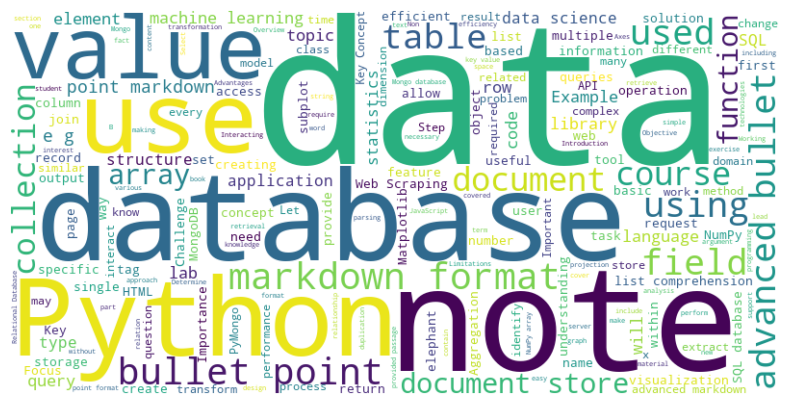

In [ ]:
from wordcloud import WordCloud

def generate_word_cloud(text):
    wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Example usage
generate_word_cloud(' '.join([note for note in df['notes']]))

# Facilitating the review process

In [ ]:
# Preparation & Parsing of the PDF Files

 